## All you need is ♥️… And a pet!

Some of you didn't get any flower on Valentine's day but you worry not, Jerry has a solution for you. Get ready to adopt a pet!

<img src="img/dataset-cover.jpg" width="920">

Here we are going to build a classifier to predict whether an animal from an animal shelter will be adopted or not (aac_intakes_outcomes.csv, available at: https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes/version/1#aac_intakes_outcomes.csv). You will be working with the following features:

1. *animal_type:* Type of animal. May be one of 'cat', 'dog', 'bird', etc.
2. *intake_year:* Year of intake
3. *intake_condition:* The intake condition of the animal. Can be one of 'normal', 'injured', 'sick', etc.
4. *intake_number:* The intake number denoting the number of occurrences the animal has been brought into the shelter. Values higher than 1 indicate the animal has been taken into the shelter on more than one occasion.
5. *intake_type:* The type of intake, for example, 'stray', 'owner surrender', etc.
6. *sex_upon_intake:* The gender of the animal and if it has been spayed or neutered at the time of intake
7. *age_upon\_intake_(years):* The age of the animal upon intake represented in years
8. *time_in_shelter_days:* Numeric value denoting the number of days the animal remained at the shelter from intake to outcome.
9. *sex_upon_outcome:* The gender of the animal and if it has been spayed or neutered at time of outcome
10. *age_upon\_outcome_(years):* The age of the animal upon outcome represented in years
11. *outcome_type:* The outcome type. Can be one of ‘adopted’, ‘transferred’, etc.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from itertools import combinations 
import ast
from sklearn.linear_model import LogisticRegression
import seaborn as sn
%matplotlib inline

data_folder = './data/'

### A) Load the dataset and convert categorical features to a suitable numerical representation (use dummy-variable encoding). 
- Split the data into a training set (80%) and a test set (20%). Pair each feature vector with the corresponding label, i.e., whether the outcome_type is adoption or not. 
- Standardize the values of each feature in the data to have mean 0 and variance 1.

The use of external libraries is not permitted in part A, except for numpy and pandas. 
If you notice missing values in the imported entries, you have to deal with them. Make informed choices.

In [2]:
columns = ['animal_type', 'intake_year', 'intake_condition', 'intake_number', 'intake_type', 'sex_upon_intake', \
          'age_upon_intake_(years)', 'time_in_shelter_days', 'sex_upon_outcome', 'age_upon_outcome_(years)', \
          'outcome_type']
original_data = pd.read_csv(data_folder+'aac_intakes_outcomes.csv', usecols=columns)

In [3]:
print('The length of the data with all rows is : {}'.format(len(original_data)))
original_data.dropna(inplace=True)
print('The length of the data without the rows with nan value is: {}'.format(len(original_data)))

The length of the data with all rows is : 79672
The length of the data without the rows with nan value is: 79661


In [4]:
categorical_features = ['animal_type', 'intake_condition', 'intake_type', 'sex_upon_intake', 'sex_upon_outcome']

data_encoded = pd.get_dummies(original_data,columns=categorical_features, drop_first=True )
data_encoded['outcome_type'] = (data_encoded['outcome_type'] == 'Adoption').astype(int)

print(data_encoded)


       outcome_type  age_upon_outcome_(years)  age_upon_intake_(years)  \
0                 0                 10.000000                10.000000   
1                 0                  7.000000                 7.000000   
2                 0                  6.000000                 6.000000   
3                 0                 10.000000                10.000000   
4                 0                 16.000000                16.000000   
...             ...                       ...                      ...   
79667             0                  0.038356                 0.038356   
79668             0                  2.000000                 2.000000   
79669             0                  1.000000                 1.000000   
79670             0                  0.821918                 0.410959   
79671             0                 10.000000                10.000000   

       intake_year  intake_number  time_in_shelter_days  animal_type_Cat  \
0             2017            1.0  

The code below can used to split the data to training/testing. The `data_to_split` should be the clean dataframe from A)

In [5]:
data_to_split = data_encoded

def split_set(data_to_split, ratio=0.8):
    mask = np.random.rand(len(data_to_split)) < ratio
    return [data_to_split[mask].reset_index(drop=True), data_to_split[~mask].reset_index(drop=True)]

[train, test] = split_set(data_to_split)

X_train, y_train = train.drop(columns=['outcome_type']), train['outcome_type']
X_test, y_test = test.drop(columns=['outcome_type']), test['outcome_type']

# Standardize features using training set statistics
mean = X_train.mean()
std = X_train.std()
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std  

### B) Train a logistic regression classifier on your training set. Logistic regression returns probabilities as predictions, so in order to arrive at a binary prediction, you need to put a threshold on the predicted probabilities. 
- For the decision threshold of 0.5, present the performance of your classifier on the test set by displaying the confusion matrix. Based on the confusion matrix, manually calculate accuracy, precision, recall, and F1-score with respect to the positive and the negative class. 

- The features in the testing set must be matched with the traning set.

- You can use the functions below to compute and plot a confusion matrix as well as compute all relevant scores

In [6]:
def compute_confusion_matrix(true_label, prediction_proba, decision_threshold=0.5): 
    
    predict_label = (prediction_proba[:,1]>decision_threshold).astype(int)   
                                                                                                                       
    TP = np.sum(np.logical_and(predict_label==1, true_label==1))
    TN = np.sum(np.logical_and(predict_label==0, true_label==0))
    FP = np.sum(np.logical_and(predict_label==1, true_label==0))
    FN = np.sum(np.logical_and(predict_label==0, true_label==1))
    
    confusion_matrix = np.asarray([[TP, FP],
                                    [FN, TN]])
    return confusion_matrix


def plot_confusion_matrix(confusion_matrix):
    [[TP, FP],[FN, TN]] = confusion_matrix
    label = np.asarray([['TP {}'.format(TP), 'FP {}'.format(FP)],
                        ['FN {}'.format(FN), 'TN {}'.format(TN)]])
    
    df_cm = pd.DataFrame(confusion_matrix, index=['Yes', 'No'], columns=['Positive', 'Negative']) 
    
    return sn.heatmap(df_cm, cmap='YlOrRd', annot=label, annot_kws={"size": 16}, cbar=False, fmt='')


def compute_all_score(confusion_matrix, t=0.5):
    [[TP, FP],[FN, TN]] = confusion_matrix.astype(float)
    
    accuracy =  (TP+TN)/np.sum(confusion_matrix)
    
    precision_positive = TP/(TP+FP) if (TP+FP) !=0 else np.nan
    precision_negative = TN/(TN+FN) if (TN+FN) !=0 else np.nan
    
    recall_positive = TP/(TP+FN) if (TP+FN) !=0 else np.nan
    recall_negative = TN/(TN+FP) if (TN+FP) !=0 else np.nan

    F1_score_positive = 2 *(precision_positive*recall_positive)/(precision_positive+recall_positive) if (precision_positive+recall_positive) !=0 else np.nan
    F1_score_negative = 2 *(precision_negative*recall_negative)/(precision_negative+recall_negative) if (precision_negative+recall_negative) !=0 else np.nan

    return [t, accuracy, precision_positive, recall_positive, F1_score_positive, precision_negative, recall_negative, F1_score_negative]

In [7]:
#fit a cute logistic regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)


LogisticRegression()

In [8]:
#evaluate the predictions
y_pred_proba = logistic_model.predict_proba(X_test)
print(y_pred_proba)

[[0.95594701 0.04405299]
 [0.76567001 0.23432999]
 [0.99494058 0.00505942]
 ...
 [0.78758209 0.21241791]
 [0.86834343 0.13165657]
 [0.98507059 0.01492941]]


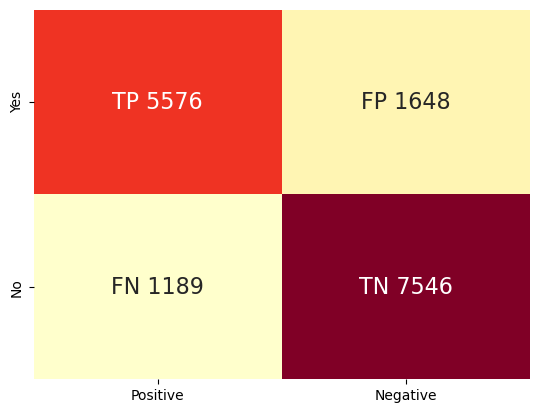

[0.5, 0.822231969421643, 0.7718715393133998, 0.8242424242424242, 0.7971977982700694, 0.8638809387521466, 0.8207526647813792, 0.8417647386915055]


In [9]:
#show confusion matrix and scores
conf_matrix = compute_confusion_matrix(y_test, y_pred_proba, decision_threshold=0.5)
plot_confusion_matrix(conf_matrix)
plt.show()

metrics = compute_all_score(conf_matrix)

print(metrics)

### C) Vary the value of the threshold in the range from 0 to 1 and visualize the value of accuracy, precision, recall  and F1-score (with respect to both classes) as a function of the threshold.

Here we expect one plot for the accuracy and then 2 sets of 3 plots for each of the classes, i.e. precision, recall and F1 score for the positive class and precision, recall and F1 score for the negative class.

### Comment on the results. What do you observe?

In clinic 3, we will focus on the AUROC curve.

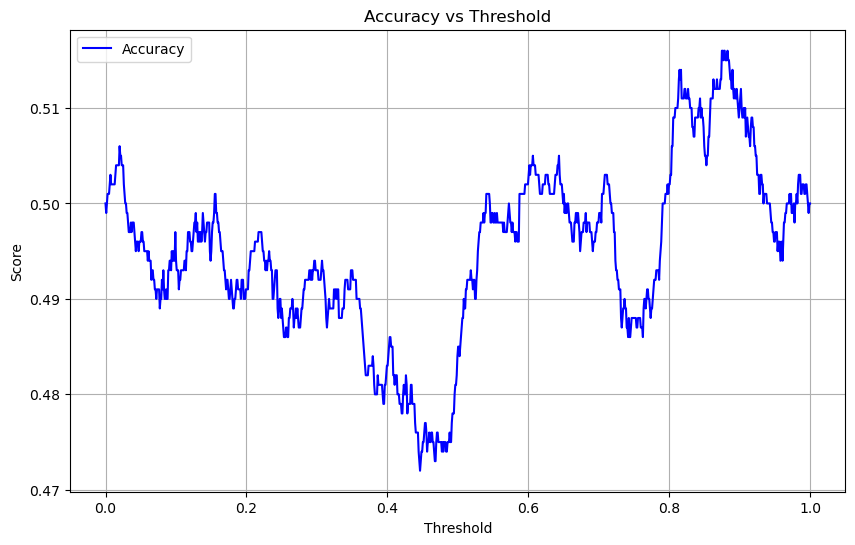

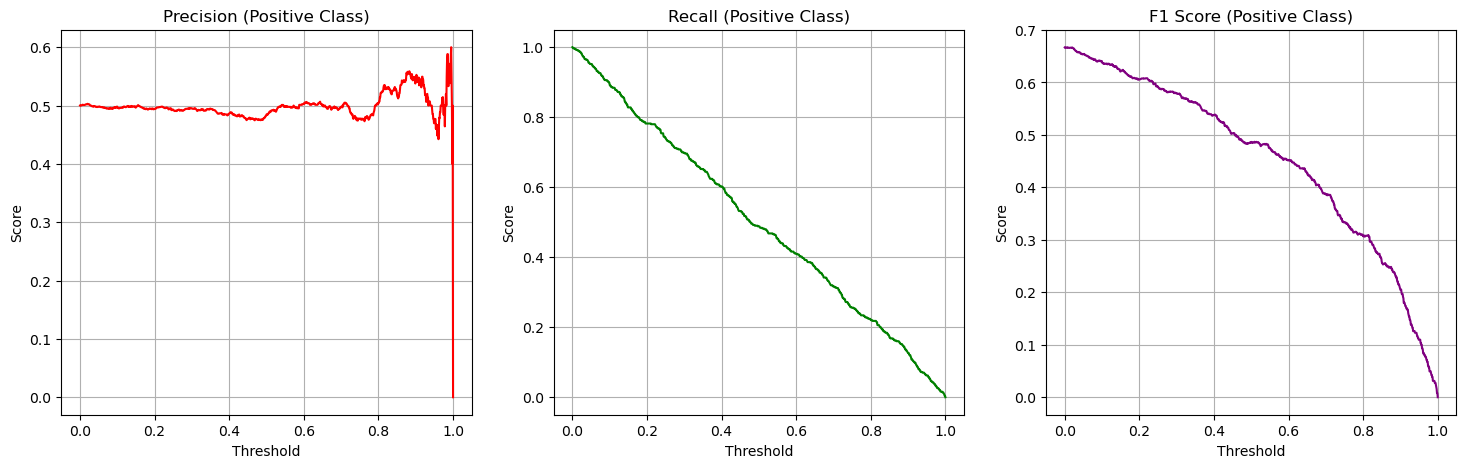

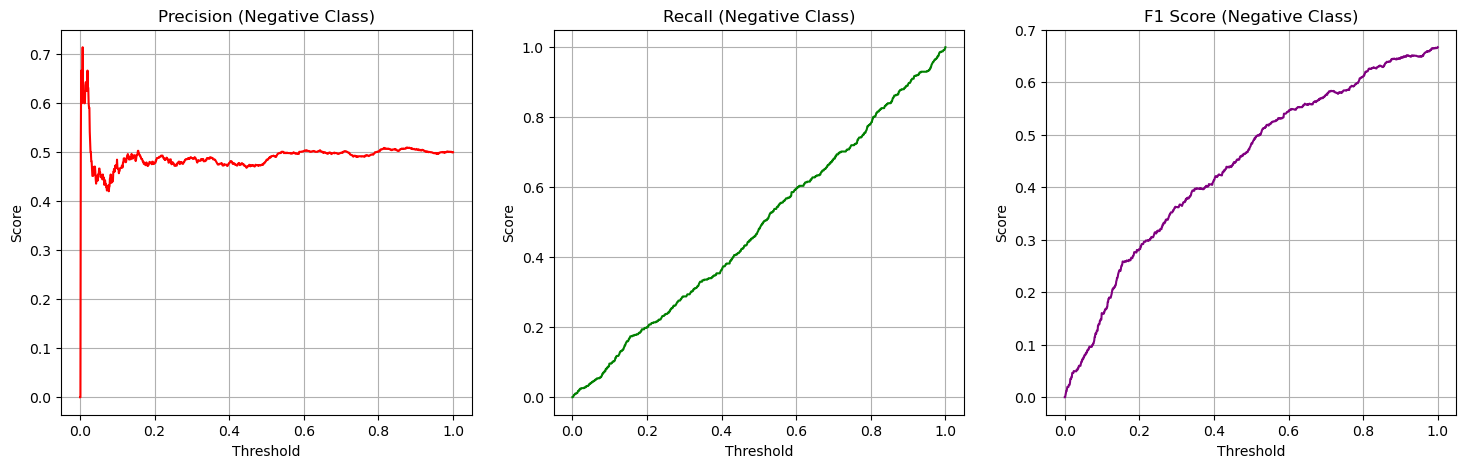

In [10]:
#show cute plots here (in total 7 plots)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np


thresholds = np.linspace(0,1,1000) #threshold form 0 to 1
y_true = np.random.randint(0, 2, 1000)  # True labels (binary classification)
y_scores = np.random.rand(1000)  # Predicted probabilities 

accuracy,precision_pos,recall_pos,f1_pos = [],[],[],[] #arrays to contain the values
precision_neg, recall_neg,f1_neg = [],[],[]

for t in thresholds:
    y_pred = (y_scores >= t).astype(int)  # Apply threshold using the y scores
    # Compute metrics
    accuracy.append(accuracy_score(y_true, y_pred))
    precision_pos.append(precision_score(y_true, y_pred, pos_label=1, zero_division=0))
    recall_pos.append(recall_score(y_true, y_pred, pos_label=1))
    f1_pos.append(f1_score(y_true, y_pred, pos_label=1))
    
    precision_neg.append(precision_score(y_true, y_pred, pos_label=0, zero_division=0))
    recall_neg.append(recall_score(y_true, y_pred, pos_label=0))
    f1_neg.append(f1_score(y_true, y_pred, pos_label=0))


#show cute plots

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracy, label="Accuracy", color="blue")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Accuracy vs Threshold")
plt.legend()
plt.grid()
plt.show()

# Plot precision, recall, F1 for positive class
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].plot(thresholds, precision_pos, label="Precision (Positive)", color="red")
axes[0].set_xlabel("Threshold")
axes[0].set_ylabel("Score")
axes[0].set_title("Precision (Positive Class)")
axes[0].grid()

axes[1].plot(thresholds, recall_pos, label="Recall (Positive)", color="green")
axes[1].set_xlabel("Threshold")
axes[1].set_ylabel("Score")
axes[1].set_title("Recall (Positive Class)")
axes[1].grid()

axes[2].plot(thresholds, f1_pos, label="F1 Score (Positive)", color="purple")
axes[2].set_xlabel("Threshold")
axes[2].set_ylabel("Score")
axes[2].set_title("F1 Score (Positive Class)")
axes[2].grid()

plt.show()

# Plot precision, recall, F1 for negative class
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].plot(thresholds, precision_neg, label="Precision (Negative)", color="red")
axes[0].set_xlabel("Threshold")
axes[0].set_ylabel("Score")
axes[0].set_title("Precision (Negative Class)")
axes[0].grid()

axes[1].plot(thresholds, recall_neg, label="Recall (Negative)", color="green")
axes[1].set_xlabel("Threshold")
axes[1].set_ylabel("Score")
axes[1].set_title("Recall (Negative Class)")
axes[1].grid()

axes[2].plot(thresholds, f1_neg, label="F1 Score (Negative)", color="purple")
axes[2].set_xlabel("Threshold")
axes[2].set_ylabel("Score")
axes[2].set_title("F1 Score (Negative Class)")
axes[2].grid()

plt.show()

// comments here //

The accuracy seems to be very low for threshold 0, then it slowly increases getting a peak around 0.9 and then decreases a bit again when hitting 1. I assume This happens because at very low thresholds, nearly everything is classified as positive, leading to high recall but low precision. At very high thresholds, nearly everything is classified as negative, leading to high precision but low recall.

For the possitive class precission, recall and f1-score decrease as the threshold increases.

For the negative class, its the opposite: recall, precission and f-1 score increase as the threshold increases.

Trade-off: When precision is high for the positive class, recall is high for the negative class. When recall is high for the positive class, precision is high for the negative class.

### D) Plot in a bar chart the coefficients of the logistic regression sorted by their contribution to the prediction.

### Interpret the results of the coefficients

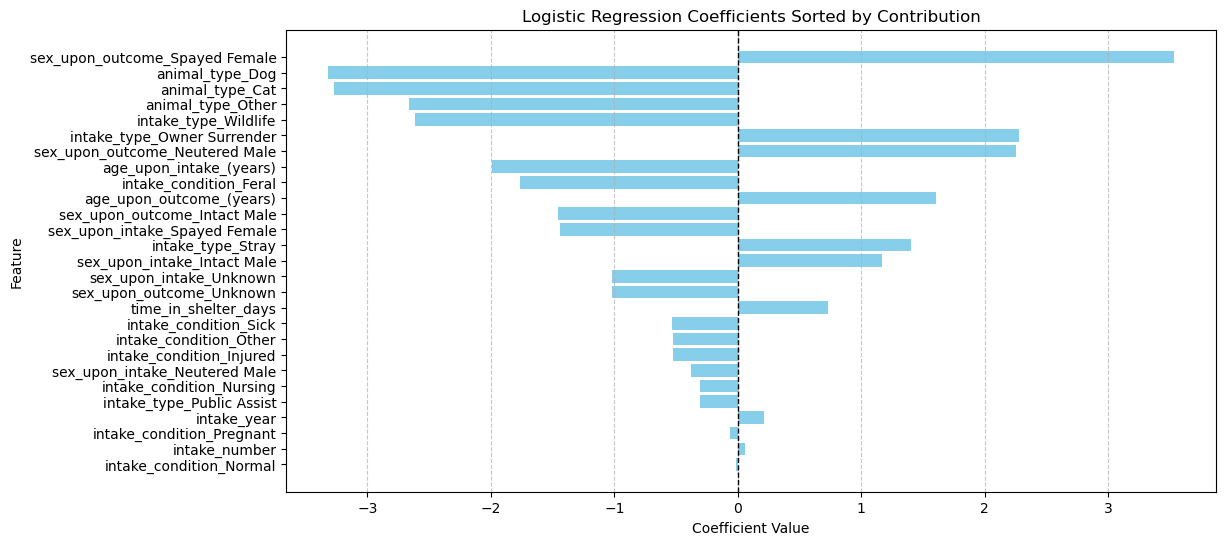

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


df = pd.read_csv(data_folder + 'aac_intakes_outcomes.csv', usecols=columns)

# Drop rows with missing values (if any)
df = df.dropna()

# Define target and features
X = df.drop(columns=['outcome_type'])  # Features
y = df['outcome_type']  # Target variable

# Convert target to binary classification (e.g., "Adopted" vs. "Other")
y = (y == "Adoption").astype(int)  # 1 for Adoption, 0 for other outcomes

# Identify categorical and numerical columns
categorical_features = ['animal_type', 'intake_condition', 'intake_type', 'sex_upon_intake', 'sex_upon_outcome']
numerical_features = ['intake_year', 'intake_number', 'age_upon_intake_(years)', 'time_in_shelter_days', 'age_upon_outcome_(years)']

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

# Define Logistic Regression pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model.fit(X_train, y_train)

# Extract feature names after transformation
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(encoded_feature_names)

# Extract coefficients
coefficients = model.named_steps['classifier'].coef_[0]

# Sort coefficients by absolute value
sorted_indices = np.argsort(np.abs(coefficients))[::-1]
sorted_features = [all_feature_names[i] for i in sorted_indices]
sorted_coefficients = coefficients[sorted_indices]

# Plot coefficients
plt.figure(figsize=(12, 6))
plt.barh(sorted_features, sorted_coefficients, color='skyblue')
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Logistic Regression Coefficients Sorted by Contribution")
plt.axvline(x=0, color="black", linestyle="--", linewidth=1)  # Reference line at zero
plt.gca().invert_yaxis()  # Invert y-axis for readability
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

// comments here //

We used the Logistic regression model from SKLearn.

Features like time in shelter days have a positive coefficient which means than a longer stay increases the possibility of adoption.

Other features like animal sick condition have a negative coefficient, which means that they ar eless likely to be adopted if they are sick animals.

Since we use one-hot encoding, each categorical feature is split into multiple binary features. For example, if animal_type_Dog has a positive coefficient, it suggests that dogs have a higher chance of adoption compared to other animals.

In this plot we portrayed all the features but maybe ti would be interesting to focus only in some of them instead of all.